In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings('ignore')

## 1. DUMP data preparation

In [2]:
def fill_df(df, amount=10000):
    now = datetime.now()
    for _ in range(amount):
        # Make some random timeset
        seconds = randint(0, 60)
        minutes = randint(0, 20)
        hours = randint(0, 1)
        timetracker = timedelta(seconds=seconds, minutes=minutes, hours=hours)
        
        # set random customer_id and product_id
        customer = randint(1, 500)
        product = randint(1, 10000)
        
        df.loc[len(df)] = [customer, product, now + timetracker]

        
# It's assumed a lot of data in dataframe, so let's try to save memory by using int32 instead of default int64 for inetegers.
# If the memory is not enought for data calculation then use dusk
df = pd.DataFrame({'customer_id': pd.Series(dtype='int32'),
                   'product_id': pd.Series(dtype='int32'),
                   'timestamp': pd.Series(dtype='datetime64[ns]'),
                  })

fill_df(df)
df.sort_values(['customer_id', 'timestamp'], inplace=True)

## 2. Class for session separation

In [3]:
class UserSessionSeparation():
    
    
    def __init__(self, max_session_minutes: float=3.):
        self.max_session_minutes = max_session_minutes
        self.df = pd.DataFrame()
    
    
    @classmethod
    def _add_preparation_columns(cls, df: pd.DataFrame) -> pd.DataFrame:
        """
        Method adds preparation columns to DF
        
        :param df: initial data frame for preparation
        :return:   pandas data frame with time_diff and dummy session_id columns
        """
        
        df['time_diff'] = df.groupby('customer_id')['timestamp'].diff().fillna(value=pd.to_timedelta(0))
        df['session_id'] = 0
        return df
    
    
    def _session_maker(self, df_group: pd.DataFrame) -> pd.Series:
        """
        Method split sessions relying on max_session_minutes for specific customer
        
        :param df_group: input data frame part with data for 1 customer
        :return:         pandas series with session_id for 1 customer
        """
        
        df = df_group[['time_diff']].reset_index(drop=True)
        session = 1
        for i in range(len(df)):
            if df.loc[i, 'time_diff']<=timedelta(minutes=self.max_session_minutes):
                df.loc[i, 'session_id'] = session
            else:
                session += 1
                df.loc[i, 'session_id'] = session
        return df['session_id'].astype('int8')
    
    
    def df_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Method transforms DF adding session_id
        
        :param df: input data frame for transformation
        :return:   transformed data frame with session_id
        """
        
        df = self._add_preparation_columns(df)
        for key in df.groupby('customer_id').groups.keys():
            df_grouped = df.groupby('customer_id').get_group(key)
            df.loc[df['customer_id']==key, 'session_id'] = self._session_maker(df_grouped).values
        
        return df
    
    
    @staticmethod
    def plot_graph(df: pd.DataFrame, customer: int=1) -> None:
        """
        Method plots testing graph
        
        :param df:       input transformed data frame  
        :param customer: choosen the customer for visualization 
        """
        
        fig_df = df.loc[df['customer_id']==customer, :].reset_index(drop=True)
        fig_df['minutes'] = fig_df['time_diff'].astype('timedelta64[s]') / 60
        fig_df['minutes'] = fig_df['minutes'].round(1)
        fig_df['cum_minutes'] = fig_df['time_diff'].astype('timedelta64[s]').cumsum() / 60

        plt.figure(figsize=(18, 8))
        plt.suptitle(f"CUSTOMER-{customer} SESSIONS", color='yellow')
        plt.title("numbers on graph corresponds to minutes delay after previous session_id", color='gold')
        sns.scatterplot(data=fig_df, x='cum_minutes', y='session_id', hue='session_id', palette='Paired')
        plt.xlabel('Cumulated minutes scince the 1st enter')
        flag = 0
        for line in range(0, fig_df.shape[0]):
            if fig_df['session_id'][line] != flag:
                flag = fig_df['session_id'][line]
                plt.text(fig_df['cum_minutes'][line]-2.4, fig_df['session_id'][line], fig_df['minutes'][line], horizontalalignment='left', size='medium', color='yellow')
        plt.show()

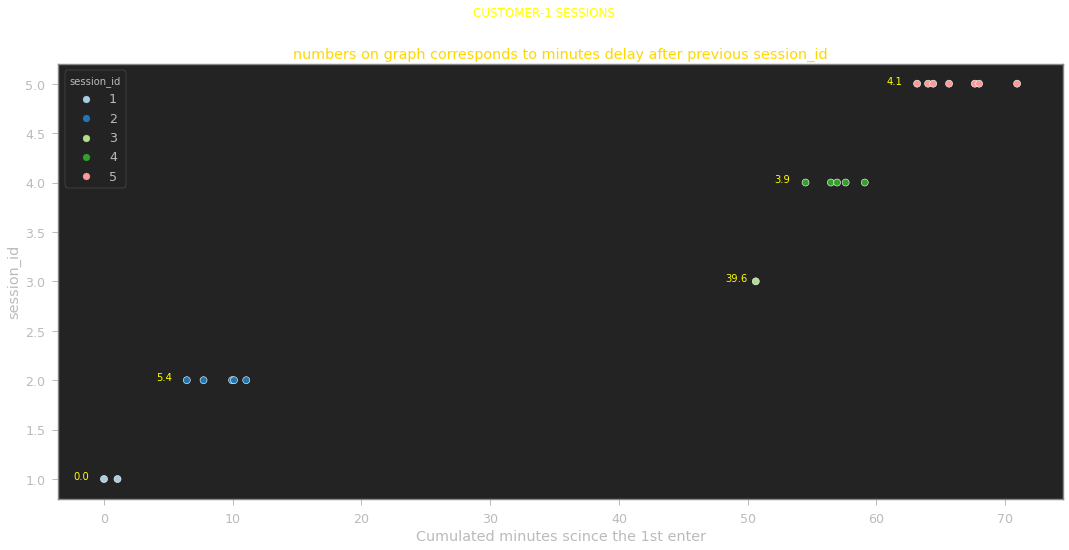

In [4]:
separator = UserSessionSeparation()
df = separator.df_transform(df)
separator.plot_graph(df)

In [5]:
df.head(20)

,customer_id,product_id,timestamp,time_diff,session_id
8937,1,4102,2022-10-31 17:08:16.222076,0 days 00:00:00,1
538,1,6355,2022-10-31 17:09:19.222076,0 days 00:01:03,1
4595,1,5341,2022-10-31 17:14:42.222076,0 days 00:05:23,2
1755,1,8542,2022-10-31 17:16:00.222076,0 days 00:01:18,2
5737,1,3805,2022-10-31 17:18:13.222076,0 days 00:02:13,2
3538,1,5511,2022-10-31 17:18:22.222076,0 days 00:00:09,2
6522,1,9862,2022-10-31 17:19:19.222076,0 days 00:00:57,2
8534,1,4974,2022-10-31 17:58:54.222076,0 days 00:39:35,3
1161,1,2194,2022-10-31 18:02:46.222076,0 days 00:03:52,4
7330,1,4011,2022-10-31 18:04:44.222076,0 days 00:01:58,4
